<div class="cite2c-biblio"></div><div class="cite2c-biblio"></div># Topic Modeling 

In this notebook we wiil texplain what we first understand by topic modelling, what are the most used methods for topic modelling and I will conclude with dynamic topic modeling.

### Topic Modelling Definition

### Topic Modelling Methods

### Dynamic Topic Modelling

In standard topic modelling we assume the order of document does not matter and therfore this approach is not suitable for time-stamped data. 
Dynamic topic modelling on the other end approach to track how languages and topic changes in a time-stamped corpus.

_cite this paper from Derek Greene here_

### Approach for the topic modelling 

The proposed approach is a two level one 

the first step is to divide the corpus into n time windows of equals durations for example days, hours, and any other time windows we want 

- On the first we apply the topic modelling techic to the document in each time windows to produce windows topics. As per the topic modelling definition the result of this step generate n windowfs topics matrix and each windows we have 2 differents matrix one is the document term matrix $W$ and the other one is the topic term matrix $H$.


- On the second  level  we apply another MNF to all topic from step one to find dynamic topic which span multiple times windows. In this step we bacically take the most important topic in each $H$ matrix form step one and stack them row wise to have another topic per time windows and term matrix which we consider as an input matrix after another NMF decomposition of this matrix we have the time topic matrix and another topic term matrix.

The dynaminc algorithm can be represented in the fololwing steps : 

- we start with an empty matrix $B$ 
- for each windows topic model $M_t$: 
    - for each row in the $M_t$ matrix select $n$ top - ranked topic term and fill the other row with zeroes
    - add the vector as a new vector of $B$
- Once all the row have been added removed all the colums with zeros everywhere

The $B$ resulted from this operation is an $i$ x $m'$ matrix where  i is the number of all the topic documents and m' is the number of most used terms in those topics . from the last step of our algo we can see that $m' <<< m $ with this we can see that we have removed all the terms which are not most used in our timeline

#### Analysis of the B matrix 

We all know that the row of the $B$ matrix are the time windows topic and the columns are the top terms in each time windows topic.

Having the new $B$ matrix we can now apply another $NMF$  factorization to get the evolution of the dynamic topic over the time. 

He factorization will of B will yield the following result $B = UV$ , in this decompozition we have 2 matrixes $U$ and $V$.

What do we have in those matrixes ? 

$U$ : the row of this matrix are the time windows topic, and the colums we have the weight of the of each dynamic topic.

$V$ : the values in the row are the dynamic topic themselves and the colums are the terms describing the dynamic topics and their weights 

We can use the weight of the dynamics topic in $U$ to track the evolution of topic over time in our document we can find when it appear and when it when it disapear in the corpus 

Now let move to the application of those methods and see what result we will get .

##### Coding the dynamic topic modelling

#### Loading the data

In the previous notebook about data cleanning we saved our cleanned dataset under `../data/cleanned_tweets_2021.csv`

Here we will just load it and apply a tfid vectorizer to it to get our documend term matrix that we will split into the different time windows 

In [2]:
import pandas as pd 
import numpy as np 

In [4]:
data = pd.read_csv('../data/cleanned_tweets_2021.csv', index_col='id', parse_dates=['created_at'])[['created_at', 'cleanned_text']]

Step one split the data into time windows 

In [5]:
min_date = data.created_at.min().strftime('%d-%b-%Y')

In [6]:
max_date = data.created_at.max().strftime('%d-%b-%Y')

From this we can see that our data where collected from {{min_date}} to {{max_date}}

In [7]:
data.shape

(1214425, 2)

let us now split it into differend time windows of different using the week as the time measurement 

In [8]:
windows_groups = data.groupby(pd.Grouper(key="created_at", freq="1W"))

In [9]:
windows_data = [df for time, df in windows_groups if not df.empty]

In [10]:
len(windows_data)

15

In [11]:
windows_data[-10]

,created_at,cleanned_text
id,,
1305295242875330560,2020-09-14 00:00:11,viemo pra
1305295372999421953,2020-09-14 00:00:42,qeum esser
1305295388610568193,2020-09-14 00:00:46,politique senser transformer positivemer vie p...
1305295468507934721,2020-09-14 00:01:05,NaN
1305295505937829889,2020-09-14 00:01:14,girl
...,...,...
1307831680040755200,2020-09-20 23:59:05,NaN
1307831730024390657,2020-09-20 23:59:17,found banking secret politician public figure ...
1307831752946315270,2020-09-20 23:59:22,retrouvonsnou lundi préparer marche eulsezvinc...


After splitting we can find that our dataset is splited in time windows of {{len(windows_data)}} weeks , with the splitting done we can continue with the topic modelling

Okay what is next is to start analyzing the topic in each time windows and build a pipeline to cobine the results

Should I build the vectorizer for all the topic or for each time windows I need to build  a tokenizer ? 

Dereek suggest to apply the preproccessing for each time windows , we are going to build the documend term matrix for every timewindows and return the document term matrix for each time windows.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
vectorizer = TfidfVectorizer(lowercase=True, 
                             strip_accents="unicode", 
                             ngram_range = (1, 2)) 

In [14]:
windows_data[1]

,created_at,cleanned_text
id,,
1266062762716905473,2020-05-28 17:44:19,rwander delegation agreed continuer bilateral ...
1266062761462767618,2020-05-28 17:44:19,jacquemain shabani appeler jeanmarc kabund tir...
1266062772405747714,2020-05-28 17:44:21,udps refuser designer candidat remplacer poste...
1266062774578413568,2020-05-28 17:44:22,jacquemain shabani appeler jeanmarc kabund tir...
1266062782581047296,2020-05-28 17:44:24,today delegations rwanda meet enhance transbor...
...,...,...
1266095024183410693,2020-05-28 19:52:31,quotidien kinshasa chance
1266095048493498369,2020-05-28 19:52:37,che frega loro hanno tasca nessuno che obbliga...
1266095057628585984,2020-05-28 19:52:39,chauffeur kényan positif covid rechercher auto...


In [15]:
windows_data = list(filter( lambda x: not x.empty, windows_data))

In [16]:
len(windows_data)

15

In [17]:
windows_data[2].head(49).iloc[1].cleanned_text

'présidence cabinet chef cabinet conseiller spécial chef etat matir'

In [18]:
vectorizer = TfidfVectorizer(lowercase=True, 
                             strip_accents="unicode", 
                             ngram_range = (1, 2)) 
doc_term_matrix = vectorizer.fit_transform(windows_data[0].cleanned_text.dropna())

In [19]:
doc_term_matrix.shape

(14561, 53641)

In [20]:
terms = vectorizer.get_feature_names()

we have the for the first time windows the a tdifdf matrix of {{doc_term_matrix.shape[0]}} rows and {{doc_term_matrix.shape[1]}} colunms, those columns are the number of words and bi_grams we have in our corpus

We can do futher preprocessing by looking into the most common ngrams we have in our corpus by using the following function 

In [21]:
from operator import itemgetter
def rank_terms( doc_term_matrix, terms ):
    # get the sums over each column
    sums = doc_term_matrix.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=itemgetter(1), reverse=True)

In [22]:
rank_terms(doc_term_matrix, terms)[:30]

[('thread', 218.83351691982568),
 ('zair', 217.28855207461424),
 ('anecdote', 214.5299626363258),
 ('anecdote zair', 214.5299626363258),
 ('thread anecdote', 214.5299626363258),
 ('covid', 96.90122318562476),
 ('mai', 91.11460570791263),
 ('pays', 81.31555017712598),
 ('jour', 72.42982024090871),
 ('ministre', 61.22501661962492),
 ('cas', 60.341136153752345),
 ('tshisekedi', 59.57607977234457),
 ('kabila', 56.10635901834737),
 ('kinshasa', 55.67061650966388),
 ('general', 54.4249999633158),
 ('president', 54.33813823016058),
 ('dire', 48.45230863613515),
 ('felix', 47.58595614377553),
 ('national', 46.989097460364775),
 ('demande', 46.66212030084455),
 ('passeport', 46.48247484132089),
 ('arreter', 46.340508559153186),
 ('felix tshisekedi', 45.19220772334301),
 ('justice', 44.06933342729221),
 ('creer', 43.74798354294154),
 ('pouvoir', 43.652306778435666),
 ('passer', 41.289866489392864),
 ('nouveau', 40.89890882983724),
 ('monde', 40.14428955122549),
 ('jeune', 39.82796088655963)]

Here we have the twenty most recent terms in the first time windows , let us know apply the topic modelling to it to see how what will result from it

In [23]:
k = 15

let us start with a k = {{k}} and then we will incorporate modele selection and performance measurenment metrics later 

Non svd is recomend to because it provide more reliable results (cite: https://www.sciencedirect.com/science/article/abs/pii/S0031320307004359?via%3Dihub)


In [24]:
from sklearn.decomposition import NMF
model = NMF(n_components=k, init="nndsvd", random_state=0)

In [25]:
model = NMF(n_components=k, init="nndsvd", random_state=0)
W = model.fit_transform(doc_term_matrix)
H = model.components_

In [26]:
W.shape

(14561, 15)

In [27]:
W[3,:].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.014, 0.015,
       0.   , 0.   , 0.   , 0.003, 0.   , 0.001])

In [28]:
H.shape

(15, 53641)

H contains the term weight for all topic and in from that we can pick one term and check how it is weigthed in each topic 

In [29]:
term_index = terms.index('passeport')
H[:, term_index].round(3)

array([0.   , 0.   , 0.005, 0.002, 0.   , 0.006, 0.   , 0.   , 0.   ,
       0.   , 0.002, 0.   , 0.026, 0.306, 0.   ])

In this we can find that the term passeport is highly linked with approximately 3 topics

Let see if now our topic make senses , we will use a functin called topic descriptor , for each topic it will return the top most ranked term in it.

In [30]:
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( (terms[term_index], H[topic_index, term_index].round(2)) )
    return top_terms

In [31]:
def print_topic_descriptor(H, terms):
    '''
    given the H term print the topic descriptor
    '''
    descriptors = []
    for topic_index in range(H.shape[0]):
        descriptor = get_descriptor( terms, H, topic_index, 10 ) 
        descriptor = [f"{x[0]}=:{x[1]}" for x in descriptor]
        descriptor = ', '.join(descriptor)
        current_topic = topic_index+1
        print(f"Topic {current_topic:.1f} === describe by : {descriptor}")
        print('=:'*20)

In [32]:
H.shape

(15, 53641)

In [33]:
print_topic_descriptor(H, terms)

Topic 1.0 === describe by : thread=:2.1, anecdote zair=:2.1, anecdote=:2.1, thread anecdote=:2.1, zair=:2.06, malheur boot=:0.01, zair malheur=:0.01, jour symboliser=:0.01, boot=:0.01, boot puant=:0.01
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
Topic 2.0 === describe by : leav villag=:0.8, african pygmie=:0.8, world shortest=:0.8, never leav=:0.8, pygmie world=:0.8, shortest set=:0.8, shortest=:0.8, people friendly=:0.8, friendly=:0.8, friendly never=:0.8
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
Topic 3.0 === describe by : rappeur damso=:0.83, creer fondation=:0.83, damso creer=:0.83, lutter vol=:0.83, vol ressource=:0.83, rappeur=:0.83, fondation afin=:0.83, afin lutter=:0.83, damso=:0.83, ressource naturel=:0.83
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
Topic 4.0 === describe by : felix tshisekedi=:0.76, felix=:0.76, dossier jour=:0.75, tshisekedi demande=:0.74, general financ=:0.74, demande audit=:0.74, audit inspection=:0.74, inspection=:0.74, financ ministre=:0.74, inspection general

From a human evaluation percepective the topic and the description make sense we can now see how the. enmbedding train in our corpus make sense in for those

### Evaluation of our models and parameter selection 

In this we will use coherence measures using embeddings to detects how good are our generated topics. 

what are those coherence measures? 

Here we will define the topice coherence which the sum of pair wise similaries of words that describes a topic? _why not weigthed it by topic weigth?_

Basically it is define as 


For each topic we can do :

$TC =  \sum_{j=2}^{N}\sum_{i=2}^{j-1}{similarity(w_i, w_j)}$


For all the topics we define it as : 

it is the mean of TC for all the topic in the $H$ matrix 

The similarity measure we use is the cosine distance between the enmbeddings of words we have in our corpus. We can use any enmbedding techinc but here we suggest to learn embedding for our corpus since we have many term specific to the congolese context which are not in the well know enmbeddings 

#### Learning words embeddings

We are planning to use pmi mutual information to train our word embeddings , and we evaluate the results and how they perform for mostly misspeled words if they are not performing well we will try to train a custom character level embeddings

We need to check [this](https://towardsdatascience.com/embedding-for-spelling-correction-92c93f835d79) to check how we can improve our embeddings to take into consideration misspled words 

Cite the facebook paper where they build a model to check for misspled charactere

This one : __*arXiv:1905.09755v1 [cs.CL] 23 May 2019*__

continue wih this research to complete the embedding trainning 

https://www.kaggle.com/alexklibisz/simple-word-vectors-with-co-occurrence-pmi-and-svd

We are planning to use to train the charactere n-gram embedding

@article{bojanowski2017enriching,
  title={Enriching Word Vectors with Subword Information},
  author={Bojanowski, Piotr and Grave, Edouard and Joulin, Armand and Mikolov, Tomas},
  journal={Transactions of the Association for Computational Linguistics},
  volume={5},
  year={2017},
  issn={2307-387X},
  pages={135--146}
}

#### Creating The Topics 

First let us create a number of differents topics models with differents k as the number of topics

In [34]:
k_min = 4
k_max = 20
topic_models = []
# try each value of k
for k in range(k_min, k_max):
    model = NMF(n_components=k, init="nndsvd", random_state=0)
    W = model.fit_transform(doc_term_matrix)
    H = model.components_
    topic_models.append( (k,W,H) )

#### Loading words Embeddings

In the previous notebook we trained a words embedding on our corpus of tweets, let us load the emdedding model we trained and use it to calculate word similarity.

In [35]:
from gensim.models.fasttext import FastText as FT_gensim
from gensim.test.utils import datapath
from pathlib import Path

In [36]:
model_path = Path.cwd().parent.joinpath('models', 'embeddings_one_gram_fast_tweets_only').__str__()
model_gensim = FT_gensim.load(model_path)

to evaluate word embeding for our words we will be using the model.wv function that return the words vector as a numpy array.

let also build a function that return the vector enmbdding for a bigram as an average of the two words it is build with 

In [37]:
'thisisanunigram'.split(' ')

['thisisanunigram']

In [38]:
def check_bigram(word):
    '''
    check if the given word passed in parameter is a bigram or not
    '''
    if len(word.split(' ')) == 2:
        return True
    return False

In [39]:
def get_bi_grams_vector(string):
    word1, words2 = string.split(' ')
    bigram_vector = np.mean([model_gensim.wv.get_vector(word1),  model_gensim.wv.get_vector(words2)], axis=0)
    return bigram_vector

In [40]:
model_gensim.wv.get_vector('president')

array([ 2.12900341e-01, -3.69229388e+00, -5.72192955e+00,  2.51046181e+00,
       -6.66270161e+00, -6.05328083e-01, -2.96665549e+00, -7.59294569e-01,
       -3.16830492e+00, -9.70456064e-01, -1.73490787e+00,  8.57101023e-01,
       -1.16333224e-01, -1.75394261e+00, -3.08472729e+00, -2.72420144e+00,
        1.62344599e+00,  1.66454208e+00, -2.64385402e-01,  9.97361541e-01,
       -7.18931794e-01, -3.04594904e-01, -7.49851346e-01, -2.44171079e-02,
       -1.96199679e+00, -2.65796733e+00,  6.13955548e-03, -1.62095356e+00,
       -4.67886877e+00, -3.27848721e+00, -7.02117682e-01,  3.15442562e+00,
       -4.45284694e-01, -2.11127138e+00,  7.33822227e-01,  2.11628199e+00,
       -2.49914694e+00,  6.66608751e-01, -1.94228089e+00,  1.49817371e+00,
        2.85460025e-01,  2.29619169e+00, -4.94098485e-01,  4.51592684e+00,
       -1.97364056e+00,  3.65440893e+00,  1.33995616e+00, -2.40125179e+00,
        8.41637015e-01, -5.86910105e+00], dtype=float32)

In [41]:
get_bi_grams_vector('felix tshisekedi').reshape(-1, 1).shape

(50, 1)

In [42]:
w

NameError: name 'w' is not defined

In [43]:
compute_cosine_similarity(get_bi_grams_vector('felix tshisekedi'), model_gensim.wv.get_vector('president'))

NameError: name 'compute_cosine_similarity' is not defined

In [44]:
def get_word_vector(word):
    """
    chef if a word is a bigram and return the correponding enmbeddings
    """
    if check_bigram(word):
        return get_bi_grams_vector(word)
    return model_gensim.wv.get_vector(word)

In [45]:
### Todos : all those function should be put in a class topic descriptor

In [46]:
from itertools import combinations

In [47]:
topic_descriptor = get_descriptor( terms, H, topic_index, 15) 

NameError: name 'topic_index' is not defined

In [48]:
def calculate_topic_coherence(topic_descriptor):
    """
    take the term ranking and compute the corherence between the term
    """
    topics_terms = [x[0] for x in topic_descriptor]
    pairs_array = np.array(list(combinations(topics_terms, 2)))
    pairs_vectors = np.apply_along_axis(compute_cosine_similarity, 1, pairs_array)
    return pairs_vectors.mean()

In [49]:
def compute_overhall_topic_coherence(H):
    '''
    compute the overhall topic cohence for a topic model
    H is the topic term matrix
    '''
    overhall_coherence = []
    for topic_index in range(H.shape[0]):
        topic_descriptor = get_descriptor(terms, H, topic_index, 10)
        coherence = calculate_topic_coherence(topic_descriptor)
        overhall_coherence.append(coherence)
    return np.array(overhall_coherence).mean()
        
    

In [50]:
def get_best_coherence(topic_models):
    """
    return a dict of the k and the coresponding topic for ploting purpose
    """
    coherences_k = dict()
    for (k,W,H) in topic_models:
        coherence = compute_overhall_topic_coherence(H)
        coherences_k[k] = coherence
        print("for k = {} the coherence is {:.2f}".format(k, coherence))
    return coherences_k

In [51]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [52]:
def plot_topic_coherence(coherences_k):
    '''
    plot the coherence for each k in the topic model
    '''
    fig = plt.figure(figsize=(13,7))
    # create the line plot
    ax = plt.plot(coherences_k.keys(), coherences_k.values() )
    plt.xticks(list(coherences_k.keys()))
    plt.xlabel("Number of Topics")
    plt.ylabel("Mean Coherence")
    # add the points
    plt.scatter(coherences_k.keys(), coherences_k.values(), s=120)
    # find and annotate the maximum point on the plot
    ymax = max(coherences_k.values())
    best_k =  max(coherences_k, key=coherences_k.get)
    plt.annotate( "k={}".format(best_k), xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
    # show the plot
    plt.show()

In [53]:
coherences_k = get_best_coherence(topic_models)

NameError: name 'compute_cosine_similarity' is not defined

In [54]:
coherences_k

NameError: name 'coherences_k' is not defined

In [55]:
plot_topic_coherence(coherences_k)

NameError: name 'coherences_k' is not defined

- Here we are done with the coherence measure for the topic porject , 

Here are the questions that arises,

Why not combining the weigthed correlation to get the coherences in topics 
- combine also with the choice of topics by the number of words in the topic terms or take all and calculate 

In [250]:
def create_topic_model(windows_doc):
    """
    given a a dataframe of time windows generate an array of topic models
    return the list of all terms and the list of different topics models for different k
    """
    vectorizer = TfidfVectorizer(lowercase=True, 
                                 strip_accents="unicode", 
                                 ngram_range = (1, 2)) 
    doc_term_matrix = vectorizer.fit_transform(windows_doc.cleanned_text.dropna())
    terms = vectorizer.get_feature_names()
    k_min = 4
    k_max = 20
    topic_models = []
    # try each value of k
    for k in range(k_min, k_max):
        model = NMF(n_components=k, init="nndsvd", random_state=0)
        W = model.fit_transform(doc_term_matrix)
        H = model.components_
        topic_models.append( (k,W,H) )
    return topic_models, terms

### Putting everything together 

In [56]:
# %load ../topic_modeling/dynamic_nmf.py
"""
this package hold the code for the dynamic topic modeling with the nmf
"""
import pandas as pd
import numpy as np
from pathlib import Path
from gensim.models.fasttext import FastText as FT_gensim
from gensim.test.utils import datapath
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from itertools import combinations
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})


class DynamicNMF:
    def __init__(self):
        self.read_data()
        self.min_date = self.data.created_at.min().strftime('%d-%b-%Y')
        self.max_date = self.data.created_at.max().strftime('%d-%b-%Y')
        self.split_into_windows_docs()

    def read_data(self, dataset_name='cleanned_tweets_2021.csv'):
        """
        read the dataset and return it in a pandas dataframe

        Args:
            dataset_name (str, optional): [description]. Defaults to
            'cleanned_tweets_2021.csv'.
        """
        self.data_path = Path.cwd().parent.joinpath('data', dataset_name)
        self.data = pd.read_csv(self.data_path, index_col='id', 
                                parse_dates=['created_at'])
        self.data = self.data[['created_at', 'cleanned_text']]
    
    def split_into_windows_docs(self, freq='1W'):
        """
        split the data into different windows document of the given length

        Args:
            freq (str, optional): [description]. Defaults to '1W'.
        """
        self.windows_groups = self.data.groupby(pd.Grouper(key="created_at",
                                                           freq=freq))
        self.windows_data = [df for time, df in self.windows_groups if not df.empty]
    
    def create_topic_model(self, windows_doc):
        """
        given a a dataframe of time windows generate an array of topic models
        return the list of all terms and the list of different topics models
        for different k
        """
        vectorizer = TfidfVectorizer(lowercase=True,
                                     strip_accents="unicode",
                                     ngram_range=(1, 2))
        doc_term_matrix = vectorizer\
            .fit_transform(windows_doc.cleanned_text.dropna())
        terms = vectorizer.get_feature_names()
        k_min = 4
        k_max = 20
        topic_models = []
        # try each value of k
        for k in range(k_min, k_max):
            model = NMF(n_components=k, init="nndsvd", random_state=0)
            W = model.fit_transform(doc_term_matrix)
            H = model.components_
            topic_models.append((k, W, H))
        return {"topic_models": topic_models, "terms": terms}
    
    def get_descriptor(self, terms, H, topic_index, top):
        """
        get the topic descriptor for the given term

        Args:
            terms ([type]): [description]
            H ([type]): [description]
            topic_index ([type]): [description]
            top ([type]): [description]

        Returns:
            [type]: [description]
        """
        # reverse sort the values to sort the indices
        top_indices = np.argsort(H[topic_index, :])[::-1]
        # now get the terms corresponding to the top-ranked indices
        top_terms = []
        for term_index in top_indices[0:top]:
            top_terms.append((terms[term_index], 
                              H[topic_index, term_index].round(2)))
        return top_terms

    def read_wv_model(self, model_name='embeddings_one_gram_fast_tweets_only'):
        """
        read the word to vv embedding model passed in parameter

        Args:
            path ([type]): [description]
        """
        model_path = Path.cwd().parent.joinpath('models', model_name).__str__()
        self.model_gensim = FT_gensim.load(model_path)

    def check_bigram(self, word):
        """
        check if the given word passed in parameter is a bigram or not
        """
        if len(word.split(' ')) == 2:
            return True
        return False
    
    def get_bi_grams_vector(self, string):
        """
        get the vector of the bigram passed in parameter,
        this is done by using the average of the two words building the vector

        Args:
            string ([type]): [description]

        Returns:
            [type]: [description]
        """
        word1, words2 = string.split(' ')
        bigram_vector = np.mean([self.model_gensim.wv.get_vector(word1),
                                 self.model_gensim.wv.get_vector(words2)],\
                                     axis=0)
        return bigram_vector

    def compute_cosine_similarity(self, words):
        """
        This code use numpy to compute the
        cosine similarity between two given vectors
        params:
        words : a 2 d array with 2 words we are calculating the similarity for
        """
        word_1, word_2 = words[0], words[1]
        vector_1 = self.get_word_vector(word_1)
        vector_2 = self.get_word_vector(word_2)
        ma = np.linalg.norm(vector_1)
        mb = np.linalg.norm(vector_2)
        cosine_distance = (np.matmul(vector_1, vector_2))/(ma*mb)
        return cosine_distance

    def get_word_vector(self, word):
        """
        return the word vector for the corresponding word or bigram

        Args:
            word ([type]): [description]
        """
        if self.check_bigram(word):
            return self.get_bi_grams_vector(word)
        return self.model_gensim.wv.get_vector(word)

    def calculate_topic_coherence(self, topic_descriptor):
        """
        take the term ranking and compute the coherence between the term
        """
        topics_terms = [x[0] for x in topic_descriptor]
        pairs_array = np.array(list(combinations(topics_terms, 2)))
        pairs_vectors = np.apply_along_axis(self.compute_cosine_similarity, 1,
                                            pairs_array)
        return pairs_vectors.mean()

    def compute_overhall_topic_coherence(self, H, terms):
        '''
        compute the overhall topic coherence for a topic model
        H is the topic term matrix
        '''
        overhall_coherence = []
        for topic_index in range(H.shape[0]):
            topic_descriptor = self.get_descriptor(terms,
                                                   H,
                                                   topic_index, 10)
            coherence = self.calculate_topic_coherence(topic_descriptor)
            overhall_coherence.append(coherence)
        return np.array(overhall_coherence).mean()
    
    def get_best_coherence(self, topic_models, terms):
        """
        return a dict of the k
        and the coresponding topic for ploting purpose
        """
        coherence_k = dict()
        for (k, W, H) in topic_models:
            coherence = self.compute_overhall_topic_coherence(H, terms)
            coherence_k[k] = coherence
            print("for k = {} the coherence is {:.2f}".format(k, coherence))
        return coherence_k
    
    def plot_topic_coherence(self, coherences_k, axe):
        """
        plot the coherence for each k in the topic model
        """
        axe.plot(coherences_k.keys(), coherences_k.values())
        axe.set_xticks(list(coherences_k.keys()))
        axe.set_xlabel("Number of Topics")
        axe.set_ylabel("Mean Coherence")
        # add the points
        axe.scatter(coherences_k.keys(), coherences_k.values(), s=120)
        # find and annotate the maximum point on the plot
        ymax = max(coherences_k.values())
        best_k = max(coherences_k, key=coherences_k.get)
        axe.annotate("k={}".format(best_k),
                     xy=(best_k, ymax),
                     xytext=(best_k, ymax),
                     textcoords="offset points", fontsize=16)

    def plot_all_coherences(self, all_coherences_k):
        """
        plot for all windows topic model the evolution of coherence measure
        """
        fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(8, 4))
        axes = axes.flatten()
        for coherences_k, axe in zip(all_coherences_k, axes):
            self.plot_topic_coherence(coherences_k, axe)


with all the function in one machine, we can now use it to create a new topic modeling and apply the suggested method to generate the dynamic NMF

In [57]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [58]:
dynamic_nmf = DynamicNMF()
dynamic_nmf.split_into_windows_docs()
dynamic_nmf.read_wv_model()

/Users/es.py/Projects/Personal/nlp_course_coursera_russia_uni/.venv/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


for k = 4 the coherence is 0.42
for k = 5 the coherence is 0.44
for k = 6 the coherence is 0.43
for k = 7 the coherence is 0.46
for k = 8 the coherence is 0.45
for k = 9 the coherence is 0.46
for k = 10 the coherence is 0.46
for k = 11 the coherence is 0.45
for k = 12 the coherence is 0.46
for k = 13 the coherence is 0.45
for k = 14 the coherence is 0.46
for k = 15 the coherence is 0.48
for k = 16 the coherence is 0.47
for k = 17 the coherence is 0.47
for k = 18 the coherence is 0.47
for k = 19 the coherence is 0.47
for k = 4 the coherence is 0.49
for k = 5 the coherence is 0.47
for k = 6 the coherence is 0.47
for k = 7 the coherence is 0.48
for k = 8 the coherence is 0.48
for k = 9 the coherence is 0.49
for k = 10 the coherence is 0.49
for k = 11 the coherence is 0.48
for k = 12 the coherence is 0.48
for k = 13 the coherence is 0.47
for k = 14 the coherence is 0.48
for k = 15 the coherence is 0.48
for k = 16 the coherence is 0.47
for k = 17 the coherence is 0.49
for k = 18 the coheren

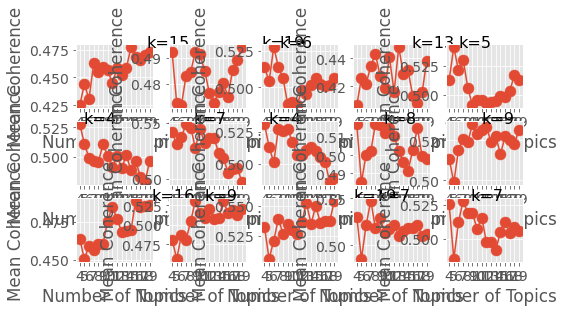

In [59]:
all_coherences = []
all_topic_models = list()
for window_data in dynamic_nmf.windows_data:
    results = dynamic_nmf.create_topic_model(window_data)
    topic_models = results.get('topic_models')
    terms = results.get('terms')
    coherences_k = dynamic_nmf.get_best_coherence(topic_models, terms)
    best_coherence = max(coherences_k, key=coherences_k.get)
    all_topic_models.append({"terms":terms, "models":topic_models, "best_k":best_coherence})
    all_coherences.append(coherences_k)
dynamic_nmf.plot_all_coherences(all_coherences)

In [60]:
def get_best_model(all_topic_models):
    '''
    loop trough all the topic models and return the best one wiht the corresponding terms 
    '''
    for topic_model in all_topic_models:
        best_k = topic_model.get('best_k')
        best_model = topic_model.get('models')[best_k-4]
        assert best_model[0] == best_k
        H = best_model[2]
        terms = topic_model.get('terms')
        yield {'terms': terms, 'model':H, "best_k":best_k}

In [61]:
H.shape

(19, 53641)

In [65]:
terms_array = np.array(terms, dtype=np.str)

In [67]:
def get_top_terms_per_model(H, terms, top_terms=15):
    '''
    given an H matrix and the terms return n tops terms in for each topic in the matrix in 
    '''
    top_indices = np.flip(np.argsort(H))
    terms_array = np.array(terms, dtype=np.str)
    top_terms = np.take(terms_array, top_indices)[::-1, :top_terms]
    return top_terms

In [325]:
top_indices = np.flip(np.argsort(H))

In [68]:
def build_time_windows_matrix(all_topic_models):
    """
    this build the $B$ matrix for the dynamic topic modelling 
    """
    best_models = get_best_model(all_topic_models)
    all_topic_matrix = list()
    for best_model in best_models:
        H = best_model.get('model')
        terms = best_model.get('terms')
        top_terms = get_top_terms_per_model(H, terms)
        all_topic_matrix.append(top_terms)
    return np.concatenate(all_topic_matrix, axis=0)

In [69]:
matrix_b = build_time_windows_matrix(all_topic_models)

In [70]:
matrix_b.shape

(148, 15)

In [71]:
def remove_space_in_bigram(matrix_b):
    return np.vectorize(lambda x: x.replace(' ', '_'))(matrix_b)

In [72]:
matrix_b = remove_space_in_bigram(matrix_b)

In [73]:
def matrix_to_sentence(matrix_b):
    return np.apply_along_axis(lambda x : ' '.join(x), 1, matrix_b)

In [74]:
matrix_b = matrix_to_sentence(matrix_b)

In [75]:
matrix_b.shape

(148,)

In [76]:
vectorizer_all_topics = TfidfVectorizer(lowercase=True, 
                             strip_accents="unicode", 
                             ngram_range = (1, 1)) 
all_doc_term_matrix = vectorizer_all_topics.fit_transform(matrix_b)

In [77]:
dynamic_model = NMF(n_components=14, init="nndsvd", random_state=0)
U = dynamic_model.fit_transform(all_doc_term_matrix)
V = dynamic_model.components_

In [78]:
dynamic_terms = vectorizer_all_topics.get_feature_names()

In [79]:
V.shape

(14, 1863)

In [80]:
print_topic_descriptor(V, dynamic_terms)

Topic 1.0 === describe by : felix_tshisekedi=:0.45, felix=:0.45, tshisekedi=:0.44, tshilombo=:0.42, tshisekedi_tshilombo=:0.42, felixantoin_tshisekedi=:0.39, felixantoin=:0.39, chef_felixantoin=:0.39, chef=:0.27, felixantoine=:0.18
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
Topic 2.0 === describe by : rtvnews_rtvonlin=:0.35, breakingnews_newsupdat=:0.35, breakingnew=:0.35, new=:0.35, new_rtvnews=:0.35, rtv=:0.35, rtv_new=:0.35, newsupdat=:0.35, breakingnews=:0.35, rtvnews=:0.35
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
Topic 3.0 === describe by : pretendre_combattre=:0.32, evangeliste_pretendre=:0.32, accuser_enfant=:0.32, sorcier_pretre=:0.32, evangeliste=:0.32, sorcier=:0.32, combattre_demon=:0.32, demon_kinshaser=:0.32, demon=:0.32, enfant_sorcier=:0.32
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
Topic 4.0 === describe by : siler_holocaust=:0.34, one_talking=:0.34, siler=:0.34, hold=:0.34, holocaust=:0.34, holocaust_happening=:0.34, nigerier_siler=:0.34, happening_one=:0.34, talking_hold=

In [81]:
U.argsort()

array([[ 0,  1,  2, ..., 12, 13, 11],
       [ 0,  1,  2, ..., 12, 13, 11],
       [ 0,  1,  2, ...,  7, 12, 11],
       ...,
       [ 0,  1,  2, ..., 13,  4, 12],
       [ 0,  1,  2, ..., 13,  6,  9],
       [ 0,  1,  2, ..., 12, 13, 11]])

In [82]:
np.flip(U.argsort())[::-1][0]

array([11, 13, 12, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [83]:
np.take(U, U.argsort())

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.59689515],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.59689515],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.59689515],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.59689515]])

### next step is the analysis of the dynamic topics

In this step we will analyse the topic generated by applying the topic modeling to the $B$

Let us plot the topics per timewindows documents matrixes

In [84]:
best_models = get_best_model(all_topic_models)
all_best_k = [model.get('best_k') for model in best_models]

In [85]:
from itertools import accumulate

In [86]:
all_best_k

[15, 19, 6, 13, 5, 4, 7, 4, 8, 9, 16, 9, 19, 7, 7]

In [87]:
cumm_best_k = list(accumulate(all_best_k))

In [88]:
time_windows_doc_topics = pd.DataFrame(data=U.round(3), columns=[f"topic_{i+1}" for i in range(U.shape[1])])

In [89]:
time_windows_doc_topics.index.name = "time_windows_topic"

In [90]:
time_windows_doc_topics.index

RangeIndex(start=0, stop=148, step=1, name='time_windows_topic')

In [91]:
time_windows_doc_topics['time_windows'] = pd.cut(time_windows_doc_topics.index, bins=cumm_best_k, labels=[f"time_windows_{i+2}" for i in range(len(all_best_k)-1)])

In [92]:
time_windows_doc_topics['time_windows'] = time_windows_doc_topics['time_windows'].astype(str).replace({"nan": f"time_windows_{1}"})

In [93]:
time_windows_doc_topics.head(cumm_best_k[0])

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,time_windows
time_windows_topic,,,,,,,,,,,,,,,
0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.597,0.0,0.000,time_windows_1
1,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.0,0.000,time_windows_1
2,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.011,0.0,0.000,time_windows_1
3,0.201,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.0,0.000,time_windows_1
4,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.049,0.0,0.000,time_windows_1
5,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.010,0.0,0.000,time_windows_1
6,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.102,0.011,0.00,0.000,0.0,0.000,time_windows_1
7,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.0,0.000,time_windows_1
8,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.689,0.0,0.000,time_windows_1


In [94]:
time_windows_doc_topics = time_windows_doc_topics.groupby("time_windows").agg(sum)

In [95]:
time_windows_doc_topics['index'] = time_windows_doc_topics.index.map(lambda x: x.split('_')[2]).astype(int)

In [96]:
time_windows_doc_topics = time_windows_doc_topics.sort_values("index").drop('index', axis="columns")

In [97]:
time_windows_doc_topics["most_commont"]  = time_windows_doc_topics.idxmax(axis='columns', skipna=True)

In [98]:
time_windows_doc_topics

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,most_commont
time_windows,,,,,,,,,,,,,,,
time_windows_1,0.489,0.000,0.003,0.000,0.000,0.250,0.025,0.000,0.113,0.029,0.020,1.519,0.000,0.021,topic_12
time_windows_2,0.199,0.000,0.000,0.000,0.000,0.550,0.000,0.000,0.178,0.289,0.000,0.022,0.850,0.791,topic_13
time_windows_3,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.792,0.000,0.004,0.000,0.000,0.032,0.276,topic_8
time_windows_4,0.094,0.000,0.000,0.000,0.000,0.017,0.000,0.792,0.000,0.321,0.000,0.363,0.000,0.079,topic_8
time_windows_5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.068,0.249,topic_14
time_windows_6,0.000,0.000,0.836,0.000,0.000,0.053,0.000,0.000,0.000,0.530,0.000,0.000,0.053,0.000,topic_3
time_windows_7,0.000,0.000,0.836,0.000,0.000,0.000,0.000,0.000,0.187,0.000,0.019,0.233,0.001,0.000,topic_3
time_windows_8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.219,0.000,topic_13
time_windows_9,0.600,0.000,0.000,0.758,0.000,0.002,0.000,0.000,0.000,0.000,0.002,0.010,0.464,0.000,topic_4


In [99]:
print_topic_descriptor(V, dynamic_terms)

Topic 1.0 === describe by : felix_tshisekedi=:0.45, felix=:0.45, tshisekedi=:0.44, tshilombo=:0.42, tshisekedi_tshilombo=:0.42, felixantoin_tshisekedi=:0.39, felixantoin=:0.39, chef_felixantoin=:0.39, chef=:0.27, felixantoine=:0.18
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
Topic 2.0 === describe by : rtvnews_rtvonlin=:0.35, breakingnews_newsupdat=:0.35, breakingnew=:0.35, new=:0.35, new_rtvnews=:0.35, rtv=:0.35, rtv_new=:0.35, newsupdat=:0.35, breakingnews=:0.35, rtvnews=:0.35
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
Topic 3.0 === describe by : pretendre_combattre=:0.32, evangeliste_pretendre=:0.32, accuser_enfant=:0.32, sorcier_pretre=:0.32, evangeliste=:0.32, sorcier=:0.32, combattre_demon=:0.32, demon_kinshaser=:0.32, demon=:0.32, enfant_sorcier=:0.32
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
Topic 4.0 === describe by : siler_holocaust=:0.34, one_talking=:0.34, siler=:0.34, hold=:0.34, holocaust=:0.34, holocaust_happening=:0.34, nigerier_siler=:0.34, happening_one=:0.34, talking_hold=

let us build the datframe for our topic windows document 

In [100]:
time_windows_doc_topics = time_windows_doc_topics.drop('most_commont', axis="columns")

In [101]:
U.shape

(148, 14)

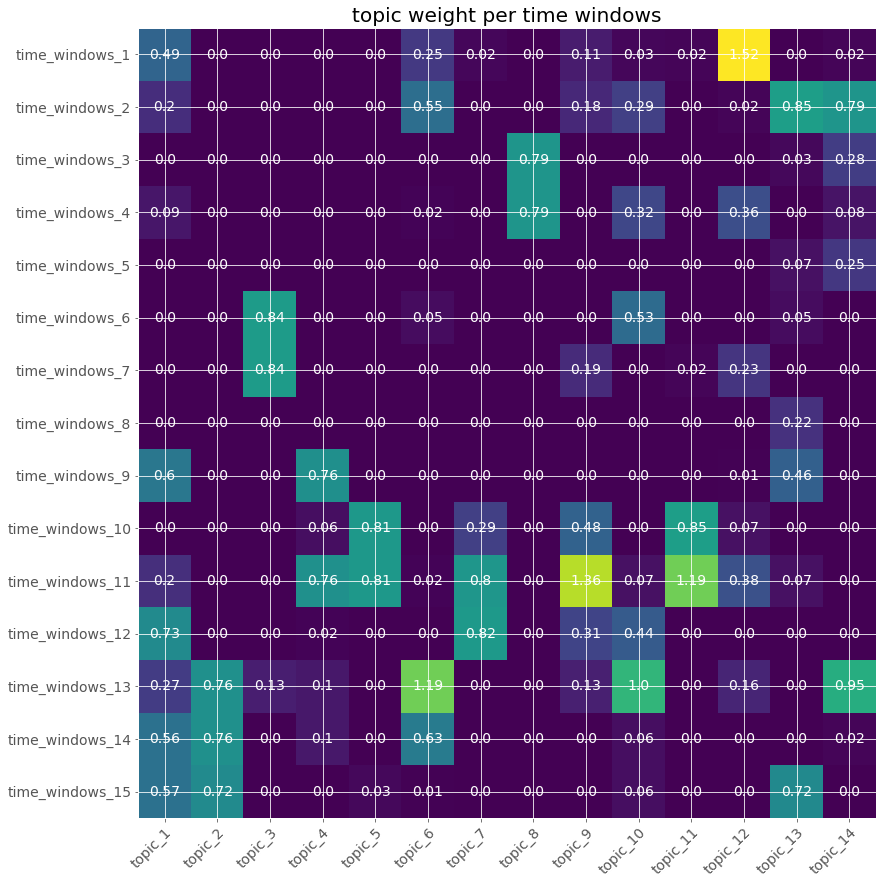

In [102]:
fig, ax = plt.subplots(figsize=(50/2, 25/2))
im = ax.imshow(time_windows_doc_topics.values)
ax.set_xticks(np.arange(time_windows_doc_topics.shape[1]))
ax.set_yticks(np.arange(time_windows_doc_topics.shape[0]))
ax.set_xticklabels(time_windows_doc_topics.columns)
ax.set_yticklabels(time_windows_doc_topics.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
for i in range(time_windows_doc_topics.shape[0]):
    for j in range(time_windows_doc_topics.shape[1]):
        text = ax.text(j, i, time_windows_doc_topics.values[i, j].round(2),
                       ha="center", va="center", color="w")
ax.set_title("topic weight per time windows")
fig.tight_layout()
plt.show()

In [124]:
from collections import Counter
words_counter = set()

In [139]:
data_summary = windows_groups.agg({'created_at': lambda x : f"{x.min().strftime('%d/%m/%Y')} - {x.max().strftime('%d/%m/%Y')}" if not x.empty else 0, 
                                   'cleanned_text': [lambda x: x.shape[0], lambda x: x.str.split().explode().nunique()]})

In [146]:
data_summary.columns = ['timeframe', 'number of tweets', 'vocabulary size']

In [150]:
data_summary = data_summary.reset_index(drop=True)

In [151]:
data_summary.to_latex(index=False)

'\\begin{tabular}{lrr}\n\\toprule\n               timeframe &  number of tweets &  vocabulary size \\\\\n\\midrule\n 13/05/2020 - 17/05/2020 &             16633 &            16848 \\\\\n                       0 &                 0 &                0 \\\\\n 28/05/2020 - 28/05/2020 &              2000 &             3911 \\\\\n                       0 &                 0 &                0 \\\\\n                       0 &                 0 &                0 \\\\\n                       0 &                 0 &                0 \\\\\n                       0 &                 0 &                0 \\\\\n                       0 &                 0 &                0 \\\\\n                       0 &                 0 &                0 \\\\\n                       0 &                 0 &                0 \\\\\n                       0 &                 0 &                0 \\\\\n                       0 &                 0 &                0 \\\\\n                       0 &                 0

In [157]:
data_summary.replace(0, np.nan).dropna(axis="rows").to_latex(index=False, float_format="{:0.0f}".format)

'\\begin{tabular}{lrr}\n\\toprule\n               timeframe &  number of tweets &  vocabulary size \\\\\n\\midrule\n 13/05/2020 - 17/05/2020 &             16633 &            16848 \\\\\n 28/05/2020 - 28/05/2020 &              2000 &             3911 \\\\\n 26/08/2020 - 30/08/2020 &             63794 &            36293 \\\\\n 31/08/2020 - 31/08/2020 &               637 &             2247 \\\\\n 08/09/2020 - 13/09/2020 &             81171 &            43738 \\\\\n 14/09/2020 - 20/09/2020 &            115086 &            56887 \\\\\n 21/09/2020 - 27/09/2020 &             98984 &            51623 \\\\\n 28/09/2020 - 04/10/2020 &            114615 &            56671 \\\\\n 05/10/2020 - 11/10/2020 &            109191 &            51339 \\\\\n 12/10/2020 - 18/10/2020 &            170758 &            53706 \\\\\n 19/10/2020 - 25/10/2020 &            181669 &            57449 \\\\\n 26/10/2020 - 27/10/2020 &             18523 &            15648 \\\\\n 05/12/2020 - 06/12/2020 &             26914

In [158]:
data_summary.head()

,timeframe,number of tweets,vocabulary size
0,13/05/2020 - 17/05/2020,16633,16848
1,0,0,0
2,28/05/2020 - 28/05/2020,2000,3911
3,0,0,0
4,0,0,0
